In [24]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification")

Skipping, found downloaded files in "./bean-leaf-lesions-classification" (use force=True to force download)


In [91]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from torchsummary import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [26]:
train_df = pd.read_csv("bean-leaf-lesions-classification/train.csv")
val_df = pd.read_csv("bean-leaf-lesions-classification/val.csv")

In [ ]:
print(train_df["category"].unique())
print(train_df.shape)
print(train_df["category"].value_counts())
train_df.head()

[0 1 2]
(1034, 2)
category
2    348
1    345
0    341
Name: count, dtype: int64


'bean-leaf-lesions-classification/train/healthy/healthy_train.305.jpg'

In [28]:
print(val_df["category"].unique())
print(val_df.shape)
val_df.head()

[0 1 2]
(133, 2)


,image:FILE,category
0,val/healthy/healthy_val.25.jpg,0
1,val/healthy/healthy_val.32.jpg,0
2,val/healthy/healthy_val.3.jpg,0
3,val/healthy/healthy_val.16.jpg,0
4,val/healthy/healthy_val.10.jpg,0


In [29]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [44]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(dataframe["category"]).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        image_path = 'bean-leaf-lesions-classification/' + self.dataframe.iloc[idx, 0]
        label = self.labels[idx]

        image = Image.open(image_path).convert("RGB")

        if transform:
            image = (self.transform(image)/255.0).to(device)

        return image, label

train_dataset = CustomImageDataset(train_df, transform)
val_dataset = CustomImageDataset(val_df, transform)

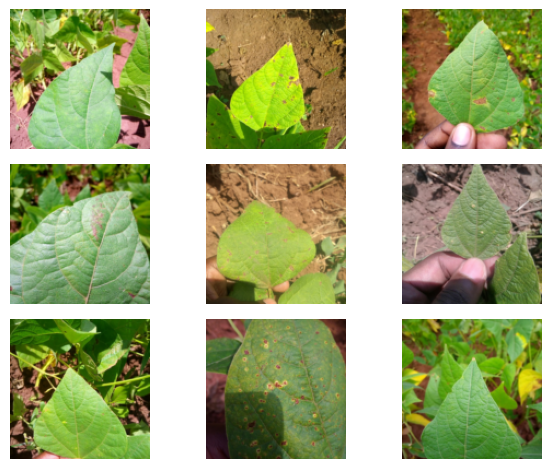

In [56]:
n_rows = 3
n_cols = 3

f, axarr = plt.subplots(ncols=n_cols, nrows=n_rows)

for row in range(n_rows):
    for col in range(n_cols):
        image = train_dataset[np.random.randint(0, len(train_dataset))][0].cpu()
        axarr[row, col].imshow((image*255.0).permute(1, 2, 0))
        axarr[row, col].axis('off')

plt.tight_layout()
plt.show()

In [57]:
Lr = 1e-3
batch_size = 32
epochs = 15

In [58]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
google_net_model = models.googlenet(weights='DEFAULT')

In [72]:
for param in google_net_model.parameters():
    param.requires_grad = True

In [73]:
google_net_model.fc

Linear(in_features=1024, out_features=1000, bias=True)

In [74]:
num_classes = len(train_df["category"].unique())
num_classes

3

In [ ]:
google_net_model.fc = nn.Linear(google_net_model.fc.in_features, num_classes)
google_net_model.fc

BasicConv2d(
  (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
)

In [92]:
google_net_model.to(device)
summary(google_net_model, input_size = (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
       BasicConv2d-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
       BasicConv2d-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 192, 32, 32]         110,592
       BatchNorm2d-9          [-1, 192, 32, 32]             384
      BasicConv2d-10          [-1, 192, 32, 32]               0
        MaxPool2d-11          [-1, 192, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          12,288
      BatchNorm2d-13           [-1, 64, 16, 16]             128
      BasicConv2d-14           [-1, 64,

In [79]:
loss = nn.CrossEntropyLoss()
optimizer = Adam(google_net_model.parameters(), lr=Lr)

total_loss_train_plot = []
total_loss_val_plot = []
total_acc_train_plot = []
total_acc_val_plot = []

for epoch in range(epochs):
    total_acc_train = 0
    total_loss_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = google_net_model(inputs)
        train_loss = loss(outputs, labels)

        total_loss_train += train_loss.item() * inputs.shape[0]

        train_loss.backward()

        train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
        total_acc_train += train_acc

        optimizer.step()

    total_loss_train_plot.append(round(total_loss_train / len(train_dataset), 4))
    total_acc_train_plot.append(round(total_acc_train / len(train_dataset) * 100, 4))

    print(f'''
    Epoch no. {epoch+1}/{epochs}
    Train Loss: {total_loss_train_plot[epoch]} 
    Train Accuracy {total_acc_train_plot[epoch]}
                ''')
    print("="*35)


    Epoch no. 1/15
    Train Loss: 0.6398 
    Train Accuracy 72.9207
                

    Epoch no. 2/15
    Train Loss: 0.4264 
    Train Accuracy 82.4952
                

    Epoch no. 3/15
    Train Loss: 0.3485 
    Train Accuracy 86.5571
                

    Epoch no. 4/15
    Train Loss: 0.2825 
    Train Accuracy 87.911
                

    Epoch no. 5/15
    Train Loss: 0.2404 
    Train Accuracy 91.1025
                

    Epoch no. 6/15
    Train Loss: 0.1752 
    Train Accuracy 94.5841
                

    Epoch no. 7/15
    Train Loss: 0.1676 
    Train Accuracy 93.3269
                

    Epoch no. 8/15
    Train Loss: 0.1514 
    Train Accuracy 94.0039
                

    Epoch no. 9/15
    Train Loss: 0.1451 
    Train Accuracy 94.971
                

    Epoch no. 10/15
    Train Loss: 0.1477 
    Train Accuracy 95.0677
                

    Epoch no. 11/15
    Train Loss: 0.0931 
    Train Accuracy 96.325
                

    Epoch no. 12/15
    Train Lo

In [81]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0

    for inputs, labels in val_loader:
        predictions = google_net_model(inputs)

        test_acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
        total_acc_test += test_acc

print(f"Acc : {round(total_acc_test / len(val_dataset) * 100, 4)}")

Acc : 84.9624


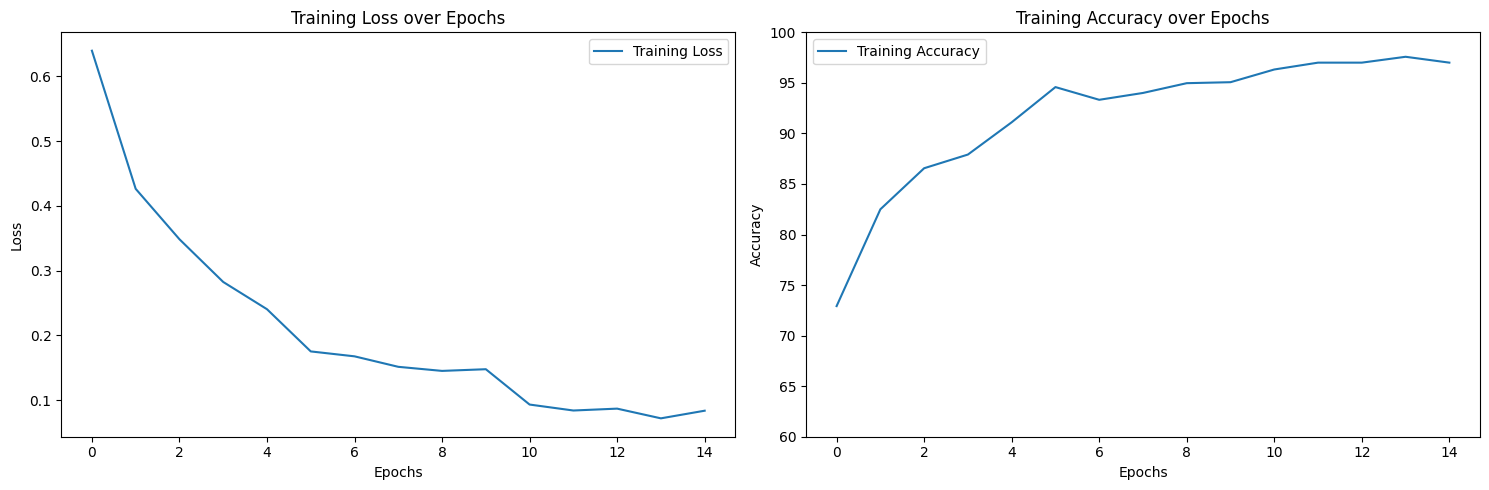

In [83]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].set_title('Training Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].set_title('Training Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([60, 100])
axs[1].legend()

plt.tight_layout()

plt.show()

## 仅微调最后一层全连接层

In [84]:
google_net_model = models.googlenet(weights='DEFAULT')
for param in google_net_model.parameters():
    param.requires_grad = False
google_net_model.fc = nn.Linear(google_net_model.fc.in_features, num_classes)
google_net_model.fc.requires_grad = True
google_net_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [85]:
loss = nn.CrossEntropyLoss()
optimizer = Adam(google_net_model.parameters(), lr=Lr)

total_loss_train_plot = []
total_loss_val_plot = []
total_acc_train_plot = []
total_acc_val_plot = []

for epoch in range(epochs):
    total_acc_train = 0
    total_loss_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = google_net_model(inputs)
        train_loss = loss(outputs, labels)

        total_loss_train += train_loss.item() * inputs.shape[0]

        train_loss.backward()

        train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
        total_acc_train += train_acc

        optimizer.step()

    total_loss_train_plot.append(round(total_loss_train / len(train_dataset), 4))
    total_acc_train_plot.append(round(total_acc_train / len(train_dataset) * 100, 4))

    print(f'''
    Epoch no. {epoch+1}/{epochs}
    Train Loss: {total_loss_train_plot[epoch]} 
    Train Accuracy {total_acc_train_plot[epoch]}
                ''')
    print("="*35)


    Epoch no. 1/15
    Train Loss: 1.0193 
    Train Accuracy 49.9033
                

    Epoch no. 2/15
    Train Loss: 0.8588 
    Train Accuracy 62.2824
                

    Epoch no. 3/15
    Train Loss: 0.8012 
    Train Accuracy 64.8936
                

    Epoch no. 4/15
    Train Loss: 0.7741 
    Train Accuracy 65.3772
                

    Epoch no. 5/15
    Train Loss: 0.7166 
    Train Accuracy 70.5029
                

    Epoch no. 6/15
    Train Loss: 0.7018 
    Train Accuracy 72.5338
                

    Epoch no. 7/15
    Train Loss: 0.6852 
    Train Accuracy 71.0832
                

    Epoch no. 8/15
    Train Loss: 0.6952 
    Train Accuracy 70.1161
                

    Epoch no. 9/15
    Train Loss: 0.6545 
    Train Accuracy 73.0174
                

    Epoch no. 10/15
    Train Loss: 0.6352 
    Train Accuracy 74.0812
                

    Epoch no. 11/15
    Train Loss: 0.6339 
    Train Accuracy 73.2108
                

    Epoch no. 12/15
    Train

In [86]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0

    for inputs, labels in val_loader:
        predictions = google_net_model(inputs)

        test_acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
        total_acc_test += test_acc

print(f"Acc : {round(total_acc_test / len(val_dataset) * 100, 4)}")

Acc : 64.6617


##  不使用预训练

In [ ]:
batch_size = 128
epochs = 15
lr = 0.01
weight_decay = 1e-4
aux_weight = 0.3  # 辅助分类器损失权重（原论文默认）

# ----------------------
# 2. 模型初始化（含预训练）
# ----------------------
google_net_model = models.GoogLeNet(
    num_classes=3,          # CIFAR-10类别数
    aux_logits=True,         # 启用辅助分类器（训练必须）
    init_weights=True        # 初始化权重（非预训练时）
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(
    google_net_model.parameters(),
    lr=lr,
    weight_decay=weight_decay
)

best_val_acc = 0.0

for epoch in range(epochs):
    google_net_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        
        # 前向传播（GoogLeNet返回主输出+2个辅助输出）
        outputs, aux1, aux2 = google_net_model(inputs)
        
        # 计算总损失（主损失 + 辅助损失）
        loss_main = criterion(outputs, labels)
        loss_aux1 = criterion(aux1, labels) * aux_weight
        loss_aux2 = criterion(aux2, labels) * aux_weight
        total_loss = loss_main + loss_aux1 + loss_aux2
        
        total_loss.backward()
        optimizer.step()

        # 统计指标（仅用主输出计算准确率）
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        running_loss += total_loss.item() * inputs.size(0)

    # 打印训练日志
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct / total
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")


Epoch [1/15], Loss: 3.9666, Acc: 0.3133
Epoch [2/15], Loss: 2.3752, Acc: 0.3356
Epoch [3/15], Loss: 1.7897, Acc: 0.3830
Epoch [4/15], Loss: 1.6643, Acc: 0.4275
Epoch [5/15], Loss: 1.6365, Acc: 0.4381
Epoch [6/15], Loss: 1.5164, Acc: 0.5164
Epoch [7/15], Loss: 1.3468, Acc: 0.5667
Epoch [8/15], Loss: 1.2820, Acc: 0.6547
Epoch [9/15], Loss: 1.3037, Acc: 0.6325
Epoch [10/15], Loss: 1.0347, Acc: 0.7234
Epoch [11/15], Loss: 0.8215, Acc: 0.8075
Epoch [12/15], Loss: 0.7112, Acc: 0.8317
Epoch [13/15], Loss: 0.6701, Acc: 0.8453
Epoch [14/15], Loss: 0.6445, Acc: 0.8317
Epoch [15/15], Loss: 0.5359, Acc: 0.8791
Training finished! Best Val Acc: 0.0000


In [96]:
with torch.no_grad():
    for inputs, labels in val_loader:
        
        # 前向传播（GoogLeNet返回主输出+2个辅助输出）
        outputs, aux1, aux2 = google_net_model(inputs)

        # 统计指标（仅用主输出计算准确率）
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        running_loss += total_loss.item() * inputs.size(0)

    # 打印训练日志
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct / total
    print(f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

Loss: 0.5795, Acc: 0.8775


In [97]:
def print_gpu_status():
    print(f"Allocated: {torch.cuda.memory_allocated()/1024**2:.2f} MB")
    print(f"Reserved:  {torch.cuda.memory_reserved()/1024**2:.2f} MB")
    print(f"Max Alloc: {torch.cuda.max_memory_allocated()/1024**2:.2f} MB")

In [98]:
print_gpu_status()

Allocated: 244.57 MB
Reserved:  796.00 MB
Max Alloc: 703.49 MB


In [105]:

# 2. 清理缓存（非必须，但释放 Reserved 内存）
torch.cuda.empty_cache()

# 3. 强制垃圾回收（可选，通常自动触发）
import gc
gc.collect()

# 4. 验证（理想情况：Allocated 接近 0）
print_gpu_status()

Allocated: 121.85 MB
Reserved:  286.00 MB
Max Alloc: 703.49 MB
